In [1]:
import csv
import torch
import torch.nn as nn
import torch.optim as optim
import cupy as np
import matplotlib.pyplot as plt
from scipy import stats
from collections import deque, namedtuple
import torch.nn.functional as F
import torch.utils.data as Data
from timeit import default_timer as timer
import random
from LoadRFFDataset import LoadRFFDataset
from sklearn.decomposition import PCA
from classifier_cnn import Classifier, Classifier2D
from classifier_cnn_getAccForRFF import getCfgs, newAccDict, test

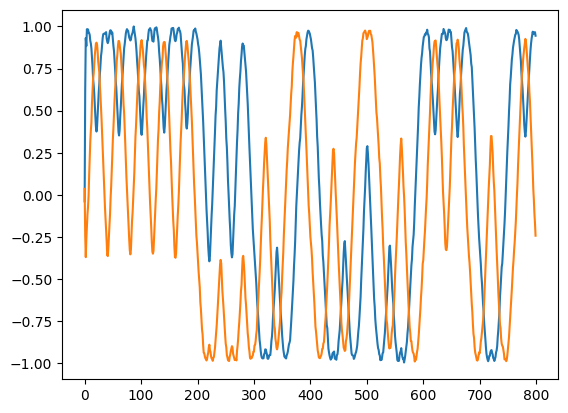

In [2]:
PATH = "../TcasRFFData/"
dataFile = "ChipCAIRprocessedType3BlockOS20len800comb220V1p2Quant16.npz"
datasets_measure, targets = LoadRFFDataset(PATH, dataFile)
plt.plot(datasets_measure[0, 0, :])
plt.plot(datasets_measure[0, 1, :])

In [5]:
datasets_220=np.zeros((220, 2, 800))
targets_220=np.zeros((220, 12))
for i in range(220):
    datasets_220[i]= np.asarray(datasets_measure[i*730])
    targets_220[i]=np.asarray(targets[i*730])

In [8]:
file = "../MCsim_for_generative_crosstest/out_200points_magn.csv"
out=[]
with open(file, newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    print(spamreader)
    i=0
    title = next(spamreader)
    total_col = len(title)
    total_points = total_col//3
    print("total column in csv.file: ", total_col)
    print("total points in MC sim: ", total_points)
    # read_all_signs = [[[], [], []] for _ in range(total_points)]
    read_all_signs = np.zeros((total_points, 3, 801))

    row_idx=0
    for row in spamreader:
        for i in range(len(row)):
            point_idx = i//3
            read_all_signs[point_idx, i%3, row_idx]=float(row[i])
        row_idx+=1

            
read_all_signs = np.array(read_all_signs)
print(read_all_signs.shape)

total column in csv.file:  588
total points in MC sim:  196
(196, 3, 801)


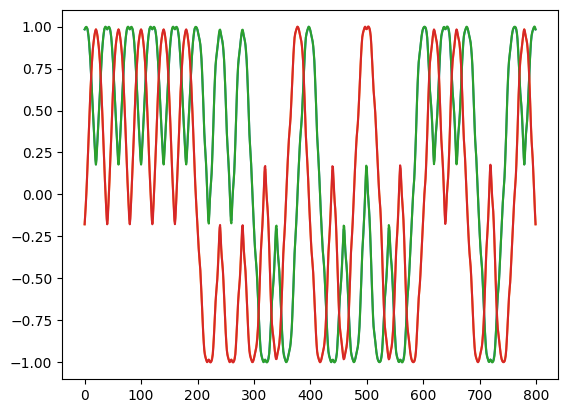

In [16]:
from scipy.interpolate import interp1d

datasets = np.zeros((196, 2, 321))
datasets[:,0,:] = read_all_signs[:,1,:321]
datasets[:,1,:] = -read_all_signs[:,2,:321]
datasets = 2*((datasets - datasets.min())/(datasets.max() - datasets.min()))-1
# plt.plot(datasets[0, 0, :])
# plt.plot(datasets[0, 1, :])
datasets_1d=np.zeros((196,2,800))
datasets_cubic=np.zeros((196,2,800))

x = np.linspace(0, 800, num=321, endpoint=True)
xnew = np.linspace(0, 800, num=800, endpoint=True)

for i in range(196):
    for ch in range(datasets.shape[1]):
        y = datasets[i,ch,:]

        f = interp1d(x.get(), y.get())
        f_cubic = interp1d(x.get(), y.get(), kind='cubic', fill_value="extrapolate")
        datasets_1d[i,ch,:]=np.asarray(f(xnew.get()))
        datasets_cubic[i,ch,:]=np.asarray(f_cubic(xnew.get()))


plt.plot(datasets_1d[0, 0, :].get())
plt.plot(datasets_1d[0, 1, :].get())
plt.plot(datasets_cubic[0, 0, :].get())
plt.plot(datasets_cubic[0, 1, :].get())

In [20]:
np.random.seed(0)
rand_idx = np.random.randint(0, datasets_measure.shape[0], datasets.shape[0])
datasets_rand = np.asarray(datasets_measure[rand_idx.get()])
err1d = np.abs(np.sum(datasets_rand-datasets_1d))/196
errcubic = np.abs(np.sum(datasets_rand-datasets_cubic))/196
print(err1d)
print(errcubic)

14.115146366426137
13.988686223064166


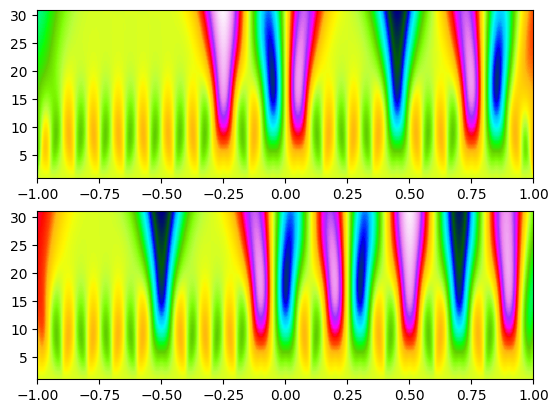

In [25]:
import scipy.io
import pywt
width=41
chs=2
preamble = scipy.io.loadmat('preamble')['preamble']

preamble_real = np.real(preamble).squeeze()
preamble_imag = np.imag(preamble).squeeze()
preamble_cwt=np.zeros((2,40,800))
p1, freqs=pywt.cwt(preamble_real.get(),np.arange(1,width).get(),'gaus1')
p2, freqs=pywt.cwt(preamble_imag.get(), np.arange(1,width).get(),'gaus1')
preamble_cwt[0]=np.asarray(p1)
preamble_cwt[1]=np.asarray(p2)
fig, axs = plt.subplots(chs)
axs[0].imshow(np.flipud(preamble_cwt[0].get()), extent=[-1, 1, 1, 31], cmap='gist_ncar', aspect='auto',
            vmax=abs(preamble_cwt[0]).max(), vmin=-abs(preamble_cwt[0]).max())
axs[1].imshow(np.flipud(preamble_cwt[1].get()), extent=[-1, 1, 1, 31], cmap='gist_ncar', aspect='auto',
            vmax=abs(preamble_cwt[1]).max(), vmin=-abs(preamble_cwt[1]).max())

In [ ]:

from scipy import signal
width=41
def test_MCsim(datasets):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("device: ", device)
    classifier = Classifier()
    # checkpoint_path = "./checkpoint/Classifier/cnn1001.pth"
    checkpoint_path = "./checkpoint/Classifier/cnn_cwtcorr_epoch1000.pth"
    checkpoint = torch.load(checkpoint_path)
    classifier = checkpoint['classifier'].to(device)
    batch_size = 32 #checkpoint['batch_size']
    train_acc_dict_vals = checkpoint['trainAccDict_curve'][-1] # 1 * 220
    val_acc_dict_vals = checkpoint['valAccDict_curve'][-1] # 1 * 220
    test_acc_dict_vals = checkpoint['test_acc_dict_vals'] # 1 * 220
    
    snrs=[35]

    plt.figure()
    for snr in snrs:
        datasets = torch.tensor(datasets)
        rffDataset=Data.TensorDataset(datasets)
        testLoader = Data.DataLoader(rffDataset, batch_size=batch_size, shuffle=True, drop_last=True)
        test_acc=[]
        testAccDict_curve=[]
        configs = getCfgs()
        test_acc_dict = newAccDict(configs)

        for batch_idx, [data] in enumerate(testLoader):
            # data = data.to(device, dtype=torch.float)
            data = data.detach().cpu().numpy()
            data_corr=np.zeros((batch_size, 2, 40, 800))
            for i in range(batch_size):
                for ch in range(2):
                    cwtmatr, freqs=pywt.cwt(data[i][ch],np.arange(1,width),'gaus1')
                    cwtmatr_yflip1 = np.flipud(cwtmatr)
                    # datasets_cwt_corr[i*n_samples+j][ch] = cwtmatr_yflip1
                    data_corr[i][ch] = signal.correlate2d(cwtmatr_yflip1, preamble_cwt[ch], mode='same')
            
            data_corr=torch.tensor(data_corr, dtype=torch.float).to(device)
            print("data size: ", data_corr.size)
            labels_ = classifier.forward(data)

            _, cfg_idx_ = torch.topk(labels_, 9, axis=1)
            cfg_idx_ = cfg_idx_.cpu().detach().numpy()
            
            for i in range(batch_size):
                cfg_ = np.zeros(12)
                cfg_[cfg_idx_[i]] = 1
                print(cfg_)
                test_acc_dict[tuple(cfg_)][0] += 1 

        for cfg in list(test_acc_dict.keys()):
            test_acc_dict[cfg] = test_acc_dict[cfg][0]
            test_acc_dict_vals = list(test_acc_dict.values()) # 220 acc values for 220 cfgs
        plt.plot(test_acc_dict_vals, label="SNR={}dB".format(snr))
        
    plt.legend()
    plt.xlabel("RFF")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs RFFs")
    plt.show()
    print(test_acc_dict_vals)


test_MCsim(datasets=datasets_cubic)

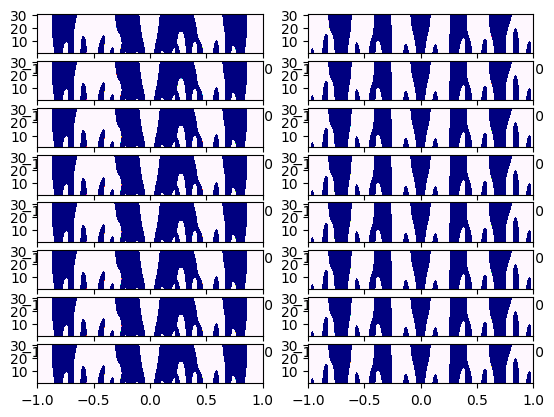

In [32]:
from scipy import signal
n=8
data_corr=np.zeros((n, 2, 40, 800))
for i in range(n):
    for ch in range(2):
        cwtmatr, freqs=pywt.cwt(datasets_cubic[2*i][ch].get(),np.arange(1,width).get(),'gaus1')
        cwtmatr_yflip1 = np.flipud(cwtmatr)
        # datasets_cwt_corr[i*n_samples+j][ch] = cwtmatr_yflip1
        data_corr[i][ch] = np.asarray(signal.correlate2d(cwtmatr_yflip1, preamble_cwt[ch].get(), mode='same'))

fig, axs = plt.subplots(n, chs)
for i in range(n):

    axs[i][0].imshow(data_corr[i][0].get(), extent=[-1, 1, 1, 31], cmap='gist_ncar', aspect='auto',
                vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
    axs[i][1].imshow(data_corr[i][1].get(), extent=[-1, 1, 1, 31], cmap='gist_ncar', aspect='auto',
                vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())

In [40]:
# r_real=np.zeros((datasets_cubic.shape[0], datasets_220.shape[0]))
# r_imag=np.zeros((datasets_cubic.shape[0], datasets_220.shape[0]))
r=np.zeros((datasets_cubic[:10].shape[0], datasets_220.shape[0]))
pool_size=730
test_size=100
def corelation(x, y): #x,y are both n-d vector
    x_mean=np.mean(x)
    y_mean=np.mean(y)
    cov_xy=0
    var_x=0
    var_y=0
    for i in range(x.shape[0]):
        cov_xy+=(x[i]-x_mean)*(y[i]-y_mean)
        var_x+=(x[i]-x_mean)*(x[i]-x_mean)
        var_y+=(y[i]-y_mean)*(y[i]-y_mean)
    corr = cov_xy/(np.sqrt(var_x*var_y))
    return corr

for i in range(datasets_cubic[:10].shape[0]):
    print(i)
    x=datasets_cubic[i] 
    for j in range(datasets_220.shape[0]):
        r_tmp=0
        for k in range(test_size):
            r_real = corelation(x[0], datasets_measure[j*pool_size+k][0])
            r_imag = corelation(x[1], datasets_measure[j*pool_size+k][1])
            r_tmp += (r_real+r_imag)/2
        r[i, j] = r_tmp/test_size

# plt.plot(r_real)
# plt.plot(r_imag)
plt.plot(r[1])

0
1
2


KeyboardInterrupt: 

[171 171 171 171 171 171 171 171 171 171]


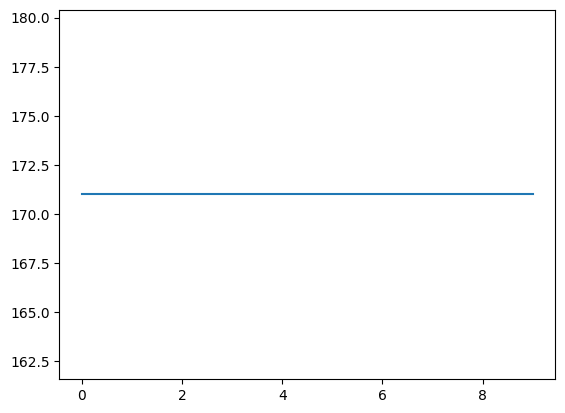

In [71]:
print(np.argmax(r, axis=1))
plt.plot(np.argmax(r, axis=1))